## Deep Convolution GAN
The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU,Dropout
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K
import random

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

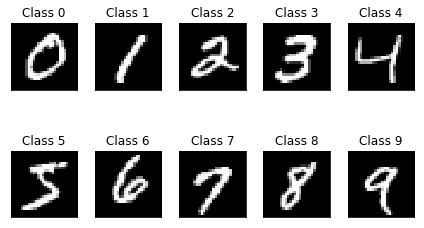

In [3]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [4]:

print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### Define Model
#### Generator

In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)


In [7]:
# Generator network
generator = Sequential()
# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))

# Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 2: 28x28x64
# generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))

# Conv 3: 28x28x32
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 4: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))


# Conv 5: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
__________

In [9]:
randseed = random.randint(0, 2**31 - 1)

## Discriminator 
discriminator = Sequential()
# Conv 1 : 14X14X64
discriminator.add(Conv2D(32,kernel_size=3,strides=2,padding='same',input_shape=(28,28,1),kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# # Dropout
# discriminator.add(Dropout(0.5))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [10]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
__________

Discriminator model visualization

In [11]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [12]:
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [13]:
discriminator.trainable = False
z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [14]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         726401    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 95489     
Total params: 821,890
Trainable params: 726,209
Non-trainable params: 95,681
_________________________________________________________________


In [17]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v for v in losses["D"]]
    g_loss = [v for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
   
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

epoch = 1/200, d_loss=0.403, g_loss=3.553                                                                                                                       


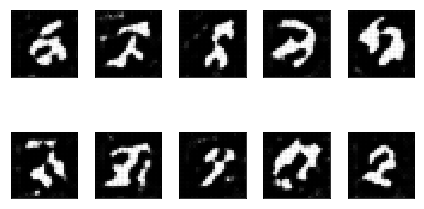

epoch = 2/200, d_loss=0.241, g_loss=3.455                                                                                                                      
epoch = 3/200, d_loss=0.204, g_loss=4.428                                                                                                                      
epoch = 4/200, d_loss=0.244, g_loss=4.131                                                                                                                      
epoch = 5/200, d_loss=0.231, g_loss=4.083                                                                                                                      
epoch = 6/200, d_loss=0.204, g_loss=4.580                                                                                                                      
epoch = 7/200, d_loss=0.202, g_loss=4.103                                                                                                                      
epoch = 8/200, d_loss=0.214, g_loss=4.75

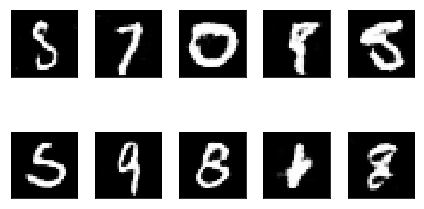

epoch = 12/200, d_loss=0.228, g_loss=4.677                                                                                                                      
epoch = 13/200, d_loss=0.248, g_loss=4.473                                                                                                                      
epoch = 14/200, d_loss=0.220, g_loss=4.474                                                                                                                      
epoch = 15/200, d_loss=0.227, g_loss=5.038                                                                                                                      
epoch = 16/200, d_loss=0.241, g_loss=4.082                                                                                                                      
epoch = 17/200, d_loss=0.206, g_loss=4.304                                                                                                                      
epoch = 18/200, d_loss=0.189, g_lo

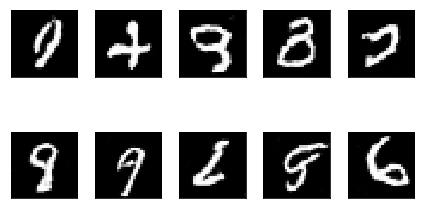

epoch = 22/200, d_loss=0.197, g_loss=4.426                                                                                                                      
epoch = 23/200, d_loss=0.206, g_loss=4.489                                                                                                                      
epoch = 24/200, d_loss=0.188, g_loss=6.113                                                                                                                      
epoch = 25/200, d_loss=0.302, g_loss=4.448                                                                                                                      
epoch = 26/200, d_loss=0.192, g_loss=5.329                                                                                                                      
epoch = 27/200, d_loss=0.186, g_loss=6.220                                                                                                                      
epoch = 28/200, d_loss=0.215, g_lo

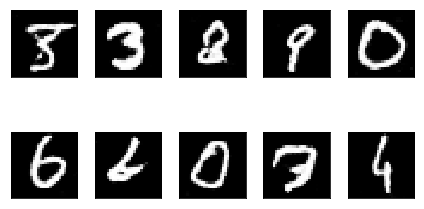

epoch = 32/200, d_loss=0.220, g_loss=5.183                                                                                                                      
epoch = 33/200, d_loss=0.334, g_loss=5.047                                                                                                                      
epoch = 34/200, d_loss=0.218, g_loss=4.296                                                                                                                      
epoch = 35/200, d_loss=0.234, g_loss=6.180                                                                                                                      
epoch = 36/200, d_loss=0.233, g_loss=6.102                                                                                                                      
epoch = 37/200, d_loss=0.212, g_loss=5.538                                                                                                                      
epoch = 38/200, d_loss=0.212, g_lo

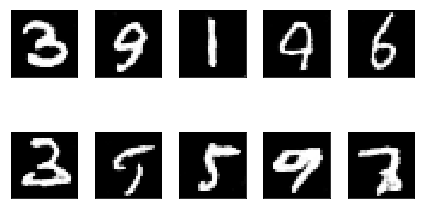

epoch = 42/200, d_loss=0.201, g_loss=5.604                                                                                                                      
epoch = 43/200, d_loss=0.240, g_loss=5.004                                                                                                                      
epoch = 44/200, d_loss=0.250, g_loss=5.442                                                                                                                      
epoch = 45/200, d_loss=0.206, g_loss=5.142                                                                                                                      
epoch = 46/200, d_loss=0.263, g_loss=5.991                                                                                                                      
epoch = 47/200, d_loss=0.198, g_loss=6.278                                                                                                                      
epoch = 48/200, d_loss=0.210, g_lo

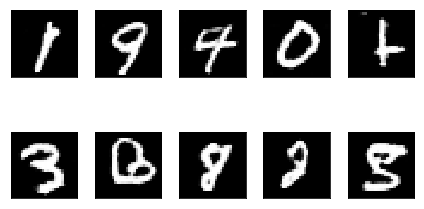

epoch = 52/200, d_loss=0.278, g_loss=4.967                                                                                                                      
epoch = 53/200, d_loss=1.065, g_loss=3.856                                                                                                                      
epoch = 54/200, d_loss=0.253, g_loss=5.111                                                                                                                      
epoch = 55/200, d_loss=0.233, g_loss=6.387                                                                                                                      
epoch = 56/200, d_loss=0.217, g_loss=5.683                                                                                                                      
epoch = 57/200, d_loss=0.241, g_loss=6.673                                                                                                                      
epoch = 58/200, d_loss=0.235, g_lo

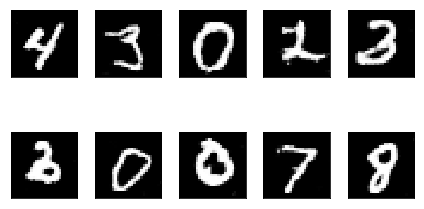

epoch = 62/200, d_loss=0.251, g_loss=4.311                                                                                                                       
epoch = 63/200, d_loss=0.270, g_loss=5.681                                                                                                                      
epoch = 64/200, d_loss=0.224, g_loss=6.646                                                                                                                      
epoch = 65/200, d_loss=0.199, g_loss=6.354                                                                                                                      
epoch = 66/200, d_loss=0.193, g_loss=6.420                                                                                                                      
epoch = 67/200, d_loss=0.281, g_loss=5.280                                                                                                                      
epoch = 68/200, d_loss=0.235, g_l

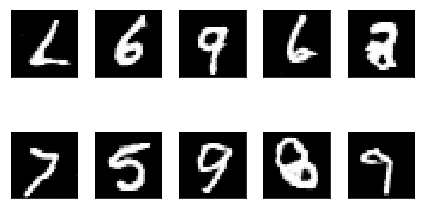

epoch = 72/200, d_loss=0.261, g_loss=5.011                                                                                                                      
epoch = 73/200, d_loss=0.200, g_loss=5.403                                                                                                                      
epoch = 74/200, d_loss=0.214, g_loss=5.092                                                                                                                      
epoch = 75/200, d_loss=0.386, g_loss=6.355                                                                                                                      
epoch = 76/200, d_loss=0.234, g_loss=6.501                                                                                                                      
epoch = 77/200, d_loss=0.251, g_loss=5.602                                                                                                                      
epoch = 78/200, d_loss=0.205, g_lo

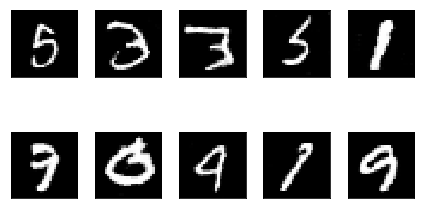

epoch = 82/200, d_loss=0.230, g_loss=6.974                                                                                                                      
epoch = 83/200, d_loss=0.242, g_loss=4.706                                                                                                                      
epoch = 84/200, d_loss=0.219, g_loss=4.836                                                                                                                       
epoch = 85/200, d_loss=0.290, g_loss=5.334                                                                                                                      
epoch = 86/200, d_loss=0.215, g_loss=6.635                                                                                                                      
epoch = 87/200, d_loss=0.217, g_loss=4.662                                                                                                                      
epoch = 88/200, d_loss=0.226, g_l

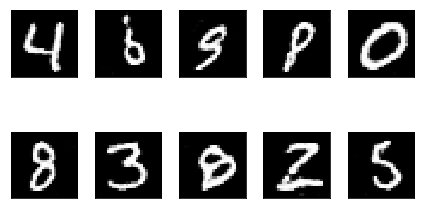

epoch = 92/200, d_loss=0.220, g_loss=6.496                                                                                                                      
epoch = 93/200, d_loss=0.223, g_loss=6.752                                                                                                                      
epoch = 94/200, d_loss=0.204, g_loss=6.323                                                                                                                      
epoch = 95/200, d_loss=0.222, g_loss=7.614                                                                                                                      
epoch = 96/200, d_loss=0.216, g_loss=4.734                                                                                                                      
epoch = 97/200, d_loss=0.300, g_loss=4.435                                                                                                                      
epoch = 98/200, d_loss=0.190, g_lo

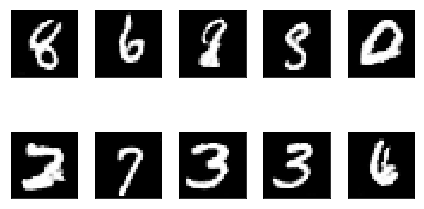

epoch = 102/200, d_loss=0.209, g_loss=6.493                                                                                                                      
epoch = 103/200, d_loss=0.210, g_loss=6.717                                                                                                                      
epoch = 104/200, d_loss=0.185, g_loss=5.295                                                                                                                      
epoch = 105/200, d_loss=0.207, g_loss=4.669                                                                                                                      
epoch = 106/200, d_loss=0.198, g_loss=5.982                                                                                                                      
epoch = 107/200, d_loss=0.223, g_loss=6.401                                                                                                                       
epoch = 108/200, d_loss=0.2

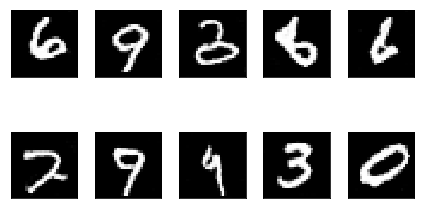

epoch = 112/200, d_loss=0.183, g_loss=5.519                                                                                                                      
epoch = 113/200, d_loss=0.205, g_loss=5.942                                                                                                                      
epoch = 114/200, d_loss=0.194, g_loss=5.046                                                                                                                      
epoch = 115/200, d_loss=0.686, g_loss=8.471                                                                                                                      
epoch = 116/200, d_loss=0.223, g_loss=6.148                                                                                                                      
epoch = 117/200, d_loss=0.322, g_loss=4.320                                                                                                                       
epoch = 118/200, d_loss=0.2

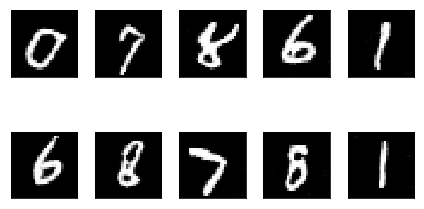

epoch = 122/200, d_loss=0.203, g_loss=8.491                                                                                                                      
epoch = 123/200, d_loss=0.226, g_loss=7.107                                                                                                                      
epoch = 124/200, d_loss=0.185, g_loss=5.077                                                                                                                      
epoch = 125/200, d_loss=0.200, g_loss=4.878                                                                                                                      
epoch = 126/200, d_loss=0.241, g_loss=4.589                                                                                                                      
epoch = 127/200, d_loss=0.286, g_loss=5.485                                                                                                                      
epoch = 128/200, d_loss=0.19

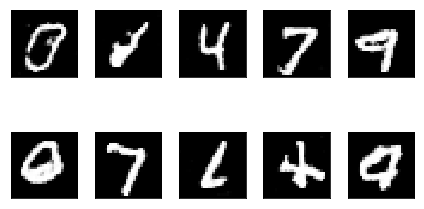

epoch = 132/200, d_loss=0.191, g_loss=6.584                                                                                                                      
epoch = 133/200, d_loss=0.202, g_loss=5.505                                                                                                                       
epoch = 134/200, d_loss=0.187, g_loss=6.326                                                                                                                      
epoch = 135/200, d_loss=0.187, g_loss=4.780                                                                                                                      
epoch = 136/200, d_loss=0.179, g_loss=6.471                                                                                                                      
epoch = 137/200, d_loss=0.216, g_loss=4.687                                                                                                                      
epoch = 138/200, d_loss=0.2

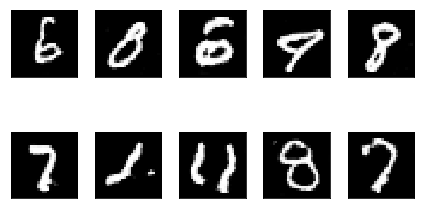

epoch = 142/200, d_loss=0.228, g_loss=5.199                                                                                                                      
epoch = 143/200, d_loss=0.293, g_loss=5.093                                                                                                                      
epoch = 144/200, d_loss=0.214, g_loss=8.150                                                                                                                      
epoch = 145/200, d_loss=0.219, g_loss=5.748                                                                                                                      
epoch = 146/200, d_loss=0.204, g_loss=5.888                                                                                                                      
epoch = 147/200, d_loss=0.327, g_loss=6.263                                                                                                                      
epoch = 148/200, d_loss=0.24

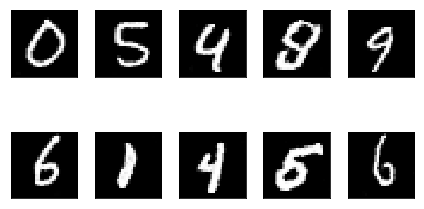

epoch = 152/200, d_loss=0.211, g_loss=4.271                                                                                                                      
epoch = 153/200, d_loss=0.187, g_loss=5.756                                                                                                                      
epoch = 154/200, d_loss=0.181, g_loss=6.376                                                                                                                      
epoch = 155/200, d_loss=0.189, g_loss=5.400                                                                                                                      
epoch = 156/200, d_loss=0.189, g_loss=4.636                                                                                                                      
epoch = 157/200, d_loss=0.229, g_loss=5.091                                                                                                                      
epoch = 158/200, d_loss=0.19

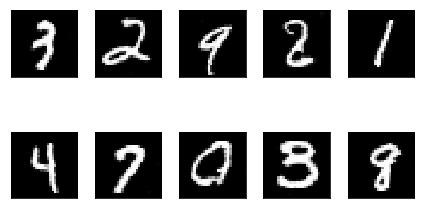

epoch = 162/200, d_loss=0.201, g_loss=5.610                                                                                                                      
epoch = 163/200, d_loss=0.192, g_loss=6.610                                                                                                                      
epoch = 164/200, d_loss=0.231, g_loss=9.464                                                                                                                       
epoch = 165/200, d_loss=0.218, g_loss=4.469                                                                                                                      
epoch = 166/200, d_loss=0.188, g_loss=5.557                                                                                                                      
epoch = 167/200, d_loss=0.289, g_loss=2.930                                                                                                                      
epoch = 168/200, d_loss=0.2

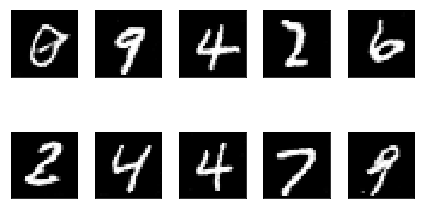

epoch = 172/200, d_loss=0.213, g_loss=5.420                                                                                                                      
epoch = 173/200, d_loss=0.429, g_loss=5.173                                                                                                                      
epoch = 174/200, d_loss=0.210, g_loss=4.151                                                                                                                      
epoch = 175/200, d_loss=0.188, g_loss=5.663                                                                                                                      
epoch = 176/200, d_loss=0.360, g_loss=4.392                                                                                                                      
epoch = 177/200, d_loss=0.206, g_loss=3.897                                                                                                                      
epoch = 178/200, d_loss=0.21

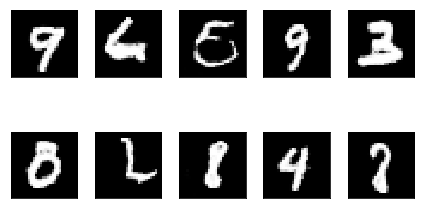

epoch = 182/200, d_loss=0.220, g_loss=6.004                                                                                                                      
epoch = 183/200, d_loss=0.182, g_loss=5.237                                                                                                                      
epoch = 184/200, d_loss=0.285, g_loss=6.015                                                                                                                       
epoch = 185/200, d_loss=0.244, g_loss=4.955                                                                                                                      
epoch = 186/200, d_loss=0.210, g_loss=6.231                                                                                                                      
epoch = 187/200, d_loss=0.231, g_loss=4.659                                                                                                                      
epoch = 188/200, d_loss=0.2

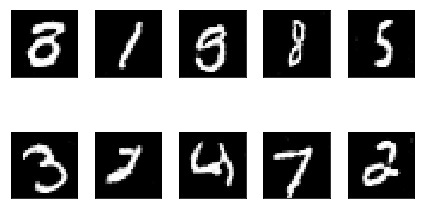

epoch = 192/200, d_loss=0.205, g_loss=4.501                                                                                                                      
epoch = 193/200, d_loss=0.229, g_loss=3.947                                                                                                                      
epoch = 194/200, d_loss=0.219, g_loss=4.657                                                                                                                       
epoch = 195/200, d_loss=0.210, g_loss=6.262                                                                                                                      
epoch = 196/200, d_loss=0.180, g_loss=6.054                                                                                                                      
epoch = 197/200, d_loss=0.240, g_loss=5.813                                                                                                                      
epoch = 198/200, d_loss=0.3

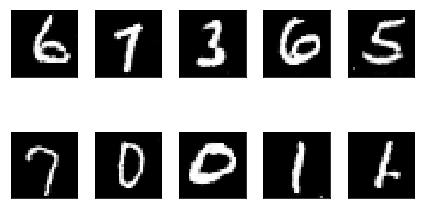

In [18]:
epochs = 200
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))


d_loss = []
d_g_loss = []
losses = {"D":d_loss, "G":d_g_loss}
for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()
losses['D'] = d_loss
losses['G'] = d_g_loss

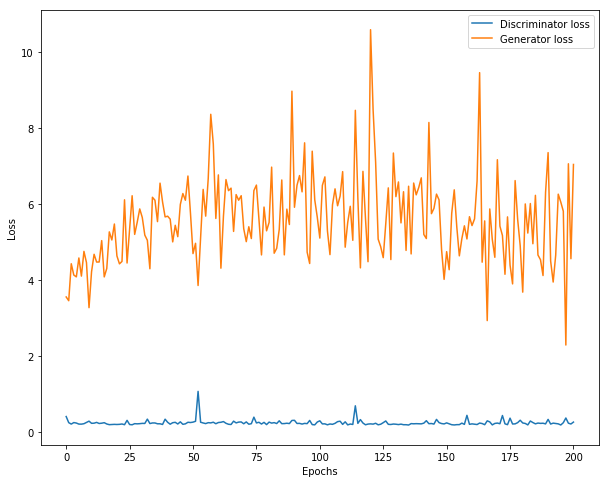

In [19]:
plot_loss(losses)